# Dogs vs. Cats，使用卷积神经网络处理二分类图片数据集

## 0. 参考资料

### Keras基础知识：
* 1.Sequential与Model模型、keras基本结构功能
* 2.Application中五款已训练模型、VGG16框架（Sequential式、Model式）解读
* 3.图像多分类训练与利用bottleneck features进行微调
* 4.人脸表情分类与识别：opencv人脸检测+Keras情绪分类
* 5.迁移学习：利用InceptionV3进行fine-tuning及预测、完整案例
* https://blog.csdn.net/sinat_26917383/article/details/72857454

### Keras实现小数量集图片分类：
* 使用“ImageDataGenerator”进行数据提升。
* https://blog.csdn.net/JinbaoSite/article/details/77435558
* https://blog.csdn.net/weiwei9363/article/details/78635674
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### fit和fit_generator两种训练方式的对比:
* ”fit_generator“方法更加节省计算机内存，
* ”fit_generator“方法可以通过图片生成器进行Data Augmentation。
* https://blog.csdn.net/u011311291/article/details/79900060

### Keras官方文档-图片生成器ImageDataGenerator：
* “ImageDataGenerator()"方法中的参数含义。
* https://keras-cn.readthedocs.io/en/latest/preprocessing/image/

### 图片生成器ImageDataGenerator的参数调整效果：
* 可视化ImageDataGenerator不同参数的图像处理效果，
* 结合实际处理的图像内容来选择适用的参数进行图像调整。
* https://blog.csdn.net/jacke121/article/details/79245732

### 在Keras的ImageDataGenerator方法中调用TensorBoard:
* 在“fit_generator()”方法中指定参数“callbacks=\[tensor_board\]”,
* 并设置日志路径“tensor_board = callbacks.TensorBoard(log_dir='./logs')”。
* https://www.cnblogs.com/touch-skyer/p/8603751.html

### steps_per_epoch以及validation_steps的参数设置：
* 设置为“原一轮样本个数/batch_size”，
* 如果未指定参数则默认为“batch_size”。
* https://blog.csdn.net/qq_31629761/article/details/81362769

### fit_generator训练方式模型的评价方法：
* 使用“model.evaluate_generator(generator, steps=None)”，
* generator为”validation_generator“，
* steps为测试集图片数量。
* https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict

### batch_size及steps_per_epoch的设置对计算性能的影响
* predict的参数batch_size设置过小导致PCI总线间的数据传输次数过多，性能低下，
* fit_generator的参数”steps_per_epoch“意为一个epoch分成多少个batch_size，
* 训练样本数量N=1000，steps_per_epoch=10，相当于一个batch_size=100。
* https://blog.csdn.net/lujiandong1/article/details/73556163?utm_source=blogxgwz1

### Keras模型的保存与加载：
* 使用”model.save('my_model.h5')“保存模型到程序根目录。
* https://blog.csdn.net/lujiandong1/article/details/55806435

---

## 1. 数据增强效果演示

### 导入需要使用到的工具包

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


### 实例化图片生成器

In [2]:
img_data_generator = ImageDataGenerator(rescale=1. / 255,
                                        rotation_range = 90,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        zoom_range = 0.3,
                                        horizontal_flip = True)

### 导入图片

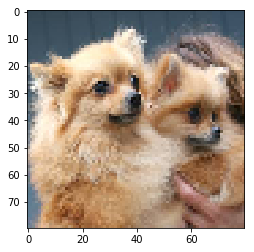

In [3]:
img_path = './images/train/dogs/77.jpg'
img = load_img(img_path, target_size=(80,80))
plt.imshow(img)

### 转化图片

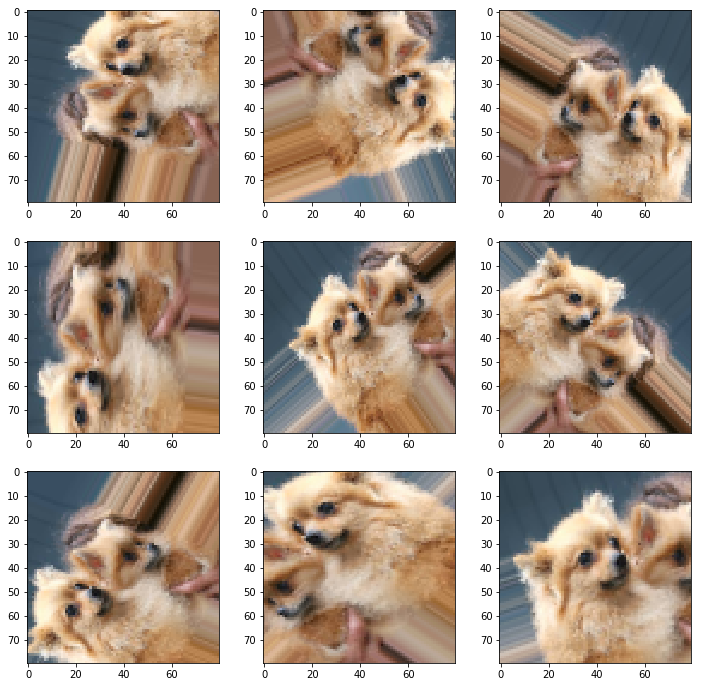

In [4]:
img_array = img_to_array(img) # 将图片转为数组
img_expand = np.expand_dims(img_array, axis=0) # 增加维度以符合generator输入格式
img_gen = img_data_generator.flow(img_expand)

plt.figure(figsize=(12,12))
for i in range(9):
    img_batch = next(img_gen)
    plt.subplot(3, 3, i+1)
    plt.imshow(img_batch[0])

---

## 2. 使用数据增强及卷积神经网络进行图片二分类

### 导入需要使用到的工具包

In [5]:
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D

import keras.callbacks as callbacks

### 预先设定常用参数

In [6]:
train_data_directory = './images/train'
test_data_directory = './images/test'

img_width, img_height = 80, 80

nb_train_samples = 800
nb_validation_samples = 200

batch_size = 20
epochs = 200

### 实例化图片生成器

In [7]:
train_data_generator = ImageDataGenerator(rescale=1. / 255,
                                          rotation_range = 90,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          zoom_range = 0.3,
                                          horizontal_flip = True)

test_data_generator = ImageDataGenerator(rescale=1. / 255)

# 在这里需要对训练数据进行数据扩展，需要进行参数设置
# 对于测试数据集我们需要使用原数据，只进行标准化操作

In [8]:
train_gen = train_data_generator.flow_from_directory(train_data_directory,
                                                           target_size=(img_width, img_height),
                                                           batch_size=batch_size,
                                                           class_mode='binary')

validation_gen = test_data_generator.flow_from_directory(test_data_directory,
                                                               target_size=(img_width, img_height),
                                                               batch_size=batch_size,
                                                               class_mode='binary')

# 二分类任务class_mode使用“binary”
# 多分类任务class_mode使用“categorical”

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 构建神经网络

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

### 训练神经网络

In [10]:
tensor_board = callbacks.TensorBoard(log_dir='./logs')

# 设置TensorBoard的log路径：”./logs“即”/Users/caiyutong/Desktop/Keras/Dogs\ vs.\ Cats/logs“

model.fit_generator(generator=train_gen,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    callbacks=[tensor_board],
                    validation_data=validation_gen,
                    validation_steps=nb_validation_samples // batch_size)

# 激活TensorFlow环境：source activate tensorflow
# 启动TensorBoard：tensorboard --logdir /Users/caiyutong/Desktop/Keras/Dogs\ vs.\ Cats/logs
# 注：”tensorboard --logdir <PATH>“中的”<PATH>“即为我们设置的日志路径的完整路径（从计算机根目录开始）

Epoch 1/200
40/40 [==============================] - 6s 140ms/step - loss: 0.6972 - acc: 0.4975 - val_loss: 0.6917 - val_acc: 0.5000
Epoch 2/200
40/40 [==============================] - 5s 135ms/step - loss: 0.6974 - acc: 0.4913 - val_loss: 0.6894 - val_acc: 0.5000
Epoch 3/200
40/40 [==============================] - 5s 131ms/step - loss: 0.6973 - acc: 0.5075 - val_loss: 0.6853 - val_acc: 0.5000
Epoch 4/200
40/40 [==============================] - 5s 125ms/step - loss: 0.6873 - acc: 0.5425 - val_loss: 0.6861 - val_acc: 0.5000
Epoch 5/200
40/40 [==============================] - 5s 132ms/step - loss: 0.6763 - acc: 0.5862 - val_loss: 0.6520 - val_acc: 0.6100
Epoch 6/200
40/40 [==============================] - 5s 130ms/step - loss: 0.6743 - acc: 0.6038 - val_loss: 0.6531 - val_acc: 0.5800
Epoch 7/200
40/40 [==============================] - 5s 130ms/step - loss: 0.6680 - acc: 0.5850 - val_loss: 0.6292 - val_acc: 0.6500
Epoch 8/200
40/40 [==============================] - 6s 147ms/step - 

40/40 [==============================] - 8s 191ms/step - loss: 0.5556 - acc: 0.7062 - val_loss: 0.5358 - val_acc: 0.7400
Epoch 63/200
40/40 [==============================] - 9s 228ms/step - loss: 0.5632 - acc: 0.7050 - val_loss: 0.5443 - val_acc: 0.7450
Epoch 64/200
40/40 [==============================] - 8s 193ms/step - loss: 0.5347 - acc: 0.7525 - val_loss: 0.5009 - val_acc: 0.7200
Epoch 65/200
40/40 [==============================] - 8s 202ms/step - loss: 0.5802 - acc: 0.7263 - val_loss: 0.5258 - val_acc: 0.7350
Epoch 66/200
40/40 [==============================] - 8s 205ms/step - loss: 0.5615 - acc: 0.7150 - val_loss: 0.5749 - val_acc: 0.6750
Epoch 67/200
40/40 [==============================] - 7s 183ms/step - loss: 0.5559 - acc: 0.7350 - val_loss: 0.5205 - val_acc: 0.7250
Epoch 68/200
40/40 [==============================] - 7s 178ms/step - loss: 0.5478 - acc: 0.7088 - val_loss: 0.5197 - val_acc: 0.7600
Epoch 69/200
40/40 [==============================] - 7s 177ms/step - loss:

40/40 [==============================] - 7s 186ms/step - loss: 0.4944 - acc: 0.7562 - val_loss: 0.5081 - val_acc: 0.7250
Epoch 124/200
40/40 [==============================] - 7s 179ms/step - loss: 0.5221 - acc: 0.7275 - val_loss: 0.5767 - val_acc: 0.7100
Epoch 125/200
40/40 [==============================] - 7s 172ms/step - loss: 0.5206 - acc: 0.7550 - val_loss: 0.5201 - val_acc: 0.7700
Epoch 126/200
40/40 [==============================] - 7s 178ms/step - loss: 0.5175 - acc: 0.7500 - val_loss: 0.4973 - val_acc: 0.7750
Epoch 127/200
40/40 [==============================] - 7s 176ms/step - loss: 0.5219 - acc: 0.7488 - val_loss: 0.5394 - val_acc: 0.7650
Epoch 128/200
40/40 [==============================] - 7s 172ms/step - loss: 0.5151 - acc: 0.7600 - val_loss: 0.4931 - val_acc: 0.7350
Epoch 129/200
40/40 [==============================] - 7s 174ms/step - loss: 0.5064 - acc: 0.7575 - val_loss: 0.5438 - val_acc: 0.7300
Epoch 130/200
40/40 [==============================] - 7s 172ms/step 

Epoch 184/200
40/40 [==============================] - 8s 205ms/step - loss: 0.4831 - acc: 0.7675 - val_loss: 0.6050 - val_acc: 0.7500
Epoch 185/200
40/40 [==============================] - 8s 192ms/step - loss: 0.4956 - acc: 0.7650 - val_loss: 0.5418 - val_acc: 0.7100
Epoch 186/200
40/40 [==============================] - 8s 192ms/step - loss: 0.4798 - acc: 0.7813 - val_loss: 0.7291 - val_acc: 0.7650
Epoch 187/200
40/40 [==============================] - 7s 169ms/step - loss: 0.5423 - acc: 0.7437 - val_loss: 0.6645 - val_acc: 0.6900
Epoch 188/200
40/40 [==============================] - 7s 168ms/step - loss: 0.5040 - acc: 0.7600 - val_loss: 0.5607 - val_acc: 0.7600
Epoch 189/200
40/40 [==============================] - 6s 158ms/step - loss: 0.4866 - acc: 0.7575 - val_loss: 0.5260 - val_acc: 0.7700
Epoch 190/200
40/40 [==============================] - 6s 162ms/step - loss: 0.5331 - acc: 0.7725 - val_loss: 0.5522 - val_acc: 0.7350
Epoch 191/200
40/40 [==============================] - 

### 评价神经网络

In [11]:
test_loss, test_acc = model.evaluate_generator(validation_gen, nb_validation_samples)

In [12]:
print("Accuracy = ",test_acc)

Accuracy =  0.7200000011920928


### 保存神经网络

In [13]:
model.save('Dogs vs. Cats.h5')

# - END -